In [1]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

True
NVIDIA RTX 2000 Ada Generation Laptop GPU


## Lora configuration 

In [ ]:

from peft import LoraConfig, get_peft_model, TaskType


lora_config_decoder = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=8,  
    lora_alpha=32,  
    target_modules=["c_attn", "c_proj"],  # GPT-2 attention projection layers
    lora_dropout=0.1,
    bias="none",
)



## Loading the dataset 

In [ ]:
from datasets import load_dataset, Dataset

t_train_dataset = load_dataset("arampacha/rsicd", split="train")
t_valid_dataset = load_dataset("arampacha/rsicd", split="valid")

new_images = []
new_captions = []

# Iterate through the original dataset and duplicate rows for each caption
for row in t_train_dataset:
    image = row['image']
    captions = row['captions']
    
    for caption in captions:
        new_images.append(image)
        new_captions.append(caption)


train_dataset = Dataset.from_dict({'image': new_images, 'captions': new_captions})

new_images = []
new_captions = []
for row in t_valid_dataset:
    image = row['image']
    captions = row['captions']
    
    for caption in captions:
        new_images.append(image)
        new_captions.append(caption)

# Create a new dataset with the modified data
valid_dataset = Dataset.from_dict({'image': new_images, 'captions': new_captions})

In [4]:
import os
import datasets
import torch
from transformers import VisionEncoderDecoderModel, AutoFeatureExtractor,AutoTokenizer
os.environ["WANDB_DISABLED"] = "true"

In [5]:
import nltk
try:
    nltk.data.find("tokenizers/punkt")
except (LookupError, OSError):
    nltk.download("punkt", quiet=True)

## Model Loading 

In [153]:
from transformers import VisionEncoderDecoderModel, AutoTokenizer, AutoFeatureExtractor

model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning").to("cuda")
# image feature extractor
feature_extractor = AutoFeatureExtractor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
# text tokenizer
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

c:\Users\wail.safi\Image-Captioning-for-Remote-Sensing-Data\venv\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


## Freezing all the encoder parameters except the last 4 layers 

In [ ]:
for param in model.encoder.parameters():
    param.requires_grad = False
N=4
for i in range(12 - N, 12):
    for param in model.encoder.encoder.layer[i].parameters():
        param.requires_grad = True

## Applay Lora to the decoder 

In [ ]:
from peft import get_peft_model, LoraConfig, TaskType

model.decoder = get_peft_model(model.decoder, lora_config_decoder)




### test the generation of a caption after applying lora 

In [ ]:
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.pad_token_id
import torch 
pixel_values = feature_extractor(images=valid_dataset[1]['image'], return_tensors="pt").pixel_values.to("cuda")

# Generate caption
with torch.no_grad():
    output_ids = model.generate(
    pixel_values,
    max_length=16,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    temperature=1.0,
)


# Decode to text
caption = tokenizer.decode(output_ids[0], skip_special_tokens=True).strip()


In [165]:
caption 

'a number of large buildings in a city at night'

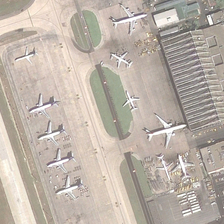

In [122]:
t_train_dataset[1]['image']

In [123]:
caption

'the airplane is being towed out on the runway'

## Process the image and the text with the feature extractor and Tokenizer respectively 

In [9]:
class ImageCapationingDataset(torch.utils.data.Dataset):
    def __init__(self, ds, max_target_length):
        self.ds = ds
        self.max_target_length = max_target_length

    def __getitem__(self, idx):
        model_inputs = {}
        image = self.ds[idx]["image"]

        # Image processing
        image_encoded = feature_extractor(images=image, return_tensors="pt").pixel_values[0]

        # Text processing with attention_mask
        encoding = tokenizer(
            self.ds[idx]["captions"], 
            padding="max_length", 
            truncation=True,
            max_length=self.max_target_length,
            return_tensors="pt"
        )

        model_inputs['pixel_values'] = image_encoded
        model_inputs['labels'] = encoding.input_ids.squeeze(0)
        model_inputs['attention_mask'] = encoding.attention_mask.squeeze(0)

        return model_inputs

    def __len__(self):
        return len(self.ds)


In [10]:
train_ds = ImageCapationingDataset(train_dataset, 64)
eval_ds = ImageCapationingDataset(valid_dataset, 64)

In [ ]:
# model.decoder = get_peft_model(model.decoder, lora_config_decoder)

c:\Users\wail.safi\Image-Captioning-for-Remote-Sensing-Data\venv\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
c:\Users\wail.safi\Image-Captioning-for-Remote-Sensing-Data\venv\Lib\site-packages\peft\mapping_func.py:79: UserWarning: The PEFT config's `base_model_name_or_path` was renamed from '' to 'None'. Please ensure that the correct base model is loaded when loading this checkpoint.
  warnings.warn(
c:\Users\wail.safi\Image-Captioning-for-Remote-Sensing-Data\venv\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


## Count the number of trainable parameters 

In [ ]:
for param in model.encoder.parameters():
    param.requires_grad = False
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for name, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
            if 'lora' in name.lower():
                print(f"LoRA param: {name}")
    print(f"Trainable params: {trainable_params:,} || All params: {all_param:,} || Trainable%: {100 * trainable_params / all_param:.2f}%")

print_trainable_parameters(model)

LoRA param: decoder.base_model.model.base_model.model.transformer.h.0.attn.c_attn.lora_A.default.weight
LoRA param: decoder.base_model.model.base_model.model.transformer.h.0.attn.c_attn.lora_B.default.weight
LoRA param: decoder.base_model.model.base_model.model.transformer.h.0.attn.c_proj.lora_A.default.weight
LoRA param: decoder.base_model.model.base_model.model.transformer.h.0.attn.c_proj.lora_B.default.weight
LoRA param: decoder.base_model.model.base_model.model.transformer.h.0.crossattention.c_attn.lora_A.default.weight
LoRA param: decoder.base_model.model.base_model.model.transformer.h.0.crossattention.c_attn.lora_B.default.weight
LoRA param: decoder.base_model.model.base_model.model.transformer.h.0.crossattention.c_proj.lora_A.default.weight
LoRA param: decoder.base_model.model.base_model.model.transformer.h.0.crossattention.c_proj.lora_B.default.weight
LoRA param: decoder.base_model.model.base_model.model.transformer.h.0.mlp.c_proj.lora_A.default.weight
LoRA param: decoder.base_

## Configuration of the training process 

In [177]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    eval_strategy="steps",     # Change to steps
    eval_steps=100,           
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    output_dir="./image-captioning-lora-output_v1",
    save_total_limit=5,
    learning_rate=5e-4,
    save_strategy="epoch",
    num_train_epochs=5,
    logging_dir="./logs",
    logging_strategy="steps",
    logging_steps=100,
)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [14]:
!pip install -q evaluate rouge_score


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define the AdamW optimizer
optimizer = AdamW(model.parameters(), lr=training_args.learning_rate)

# Define the ReduceLROnPlateau scheduler
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',  
    factor=0.1,  
    patience=3   
)


## Define the trainer 

In [ ]:
from transformers import default_data_collator

from torch.optim  import AdamW
optimizer = AdamW(model.parameters(), lr=training_args.learning_rate)


trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
  
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    data_collator=default_data_collator,
    optimizers=(optimizer, None),  # CHANGED: Keep optimizer, remove custom scheduler
)

C:\Users\wail.safi\AppData\Local\Temp\ipykernel_4240\4283442153.py:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


### Start the training 

In [180]:

trainer.train()

Step,Training Loss,Validation Loss
100,0.948700,0.583836
200,0.612100,0.509018
300,0.552400,0.482699
400,0.518900,0.465293
500,0.499400,0.451220
600,0.491600,0.457880
700,0.478400,0.446703
800,0.449100,0.446889
900,0.459100,0.433075
1000,0.442500,0.434288


TrainOutput(global_step=6825, training_loss=0.3351684635288113, metrics={'train_runtime': 26278.0398, 'train_samples_per_second': 8.309, 'train_steps_per_second': 0.26, 'total_flos': 3.9636925154014e+19, 'train_loss': 0.3351684635288113, 'epoch': 5.0})

### plot the loss 

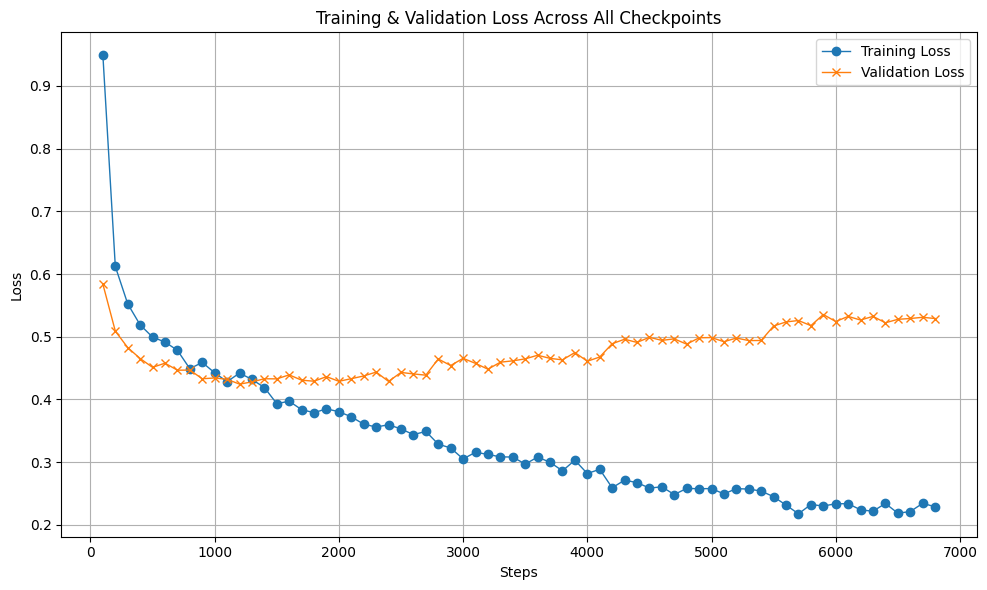

In [271]:
import os
import json
import matplotlib.pyplot as plt

# Path to the parent directory
base_dir = "image-captioning-lora-output_v1"

# Initialize global lists
global_train_steps, global_train_losses = [], []
global_eval_steps, global_eval_losses = [], []

# Loop through all checkpoint directories
for subdir in sorted(os.listdir(base_dir)):
    checkpoint_path = os.path.join(base_dir, subdir, "trainer_state.json")
    if os.path.exists(checkpoint_path):
        with open(checkpoint_path, "r") as f:
            data = json.load(f)
            for record in data["log_history"]:
                if "loss" in record:
                    global_train_steps.append(record["step"])
                    global_train_losses.append(record["loss"])
                elif "eval_loss" in record:
                    global_eval_steps.append(record["step"])
                    global_eval_losses.append(record["eval_loss"])

# Remove duplicates in case of overlapping steps
seen_train = set()
unique_train = [(s, l) for s, l in zip(global_train_steps, global_train_losses) if s not in seen_train and not seen_train.add(s)]
global_train_steps, global_train_losses = zip(*unique_train)

seen_eval = set()
unique_eval = [(s, l) for s, l in zip(global_eval_steps, global_eval_losses) if s not in seen_eval and not seen_eval.add(s)]
global_eval_steps, global_eval_losses = zip(*unique_eval)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(global_train_steps, global_train_losses, label="Training Loss", marker='o', linewidth=1)
plt.plot(global_eval_steps, global_eval_losses, label="Validation Loss", marker='x', linewidth=1)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Across All Checkpoints")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [20]:

import nltk
nltk.download('punkt')
nltk.download('punkt', download_dir='/path/to/nltk_data')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\wail.safi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /path/to/nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [21]:

trainer.train()

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss,Validation Loss
100,0.964200,0.598445
200,0.643300,0.531756
300,0.576700,0.505773
400,0.536700,0.478821
500,0.519500,0.464828
600,0.508400,0.463058
700,0.491100,0.453612
800,0.462700,0.454887
900,0.471500,0.437427
1000,0.454900,0.439138


TrainOutput(global_step=2730, training_loss=0.4602593282203535, metrics={'train_runtime': 43716.8333, 'train_samples_per_second': 1.998, 'train_steps_per_second': 0.062, 'total_flos': 1.5947823872779223e+19, 'train_loss': 0.4602593282203535, 'epoch': 2.0})

In [182]:



model.decoder.save_pretrained("vlm_full_merged_model")

In [ ]:
# from peft import PeftModel

# # Make sure your main model is wrapped as a PeftModel (LoRA was applied to the decoder)
# peft_decoder = model.decoder  # This should be a PeftModel instance

# # Step 1: Merge the LoRA adapter into the decoder
# merged_decoder = peft_decoder.merge_and_unload()

# # Step 2: Assign it back to the VLM model
# model.decoder = merged_decoder

# # Step 3: Save the full model
# model.save_pretrained("vlm_full_merged_model")



In [22]:
metrics = trainer.evaluate()
print(metrics)


{'eval_loss': 0.4246827960014343, 'eval_runtime': 444.4426, 'eval_samples_per_second': 12.308, 'eval_steps_per_second': 0.385, 'epoch': 2.0}


In [ ]:

t_dataset = load_dataset("arampacha/rsicd", split="test")
new_images = []
new_captions = []
for row in t_dataset:
    image = row['image']
    captions = row['captions']
    
    for caption in captions:
        new_images.append(image)
        new_captions.append(caption)

# Create a new dataset with the modified data
test_dataset = Dataset.from_dict({'image': new_images, 'captions': new_captions})


In [139]:
test_ds = ImageCapationingDataset(test_dataset, 64)

In [77]:
from torch.utils.data import DataLoader

test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)


In [263]:
results = []
device = "cuda" if torch.cuda.is_available() else "cpu"

for batch in test_loader:
    pixel_values = batch['pixel_values'].to(device).unsqueeze(1)  # Add batch dimension if needed
    pixel_values = pixel_values.squeeze(1) if pixel_values.dim() == 5 else pixel_values  # Handle single-channel images

    with torch.no_grad():
       output_ids = model.generate(
    pixel_values,
    max_length=64,
    do_sample=True,
    top_k=5,
    top_p=0.85,
    temperature=0.75,
    repetition_penalty=1.2,  # prevents repetitive phrases
)

    generated_captions = tokenizer.batch_decode(output_ids, skip_special_tokens=True)

    for caption in generated_captions:
        results.append(caption)


In [264]:
results

[' planes parked at airport to airport by runway',
 ' planes at airport near building full dry .',
 ' planes parked the in of airport.',
 ' planes parked the in airport by and.',
 ' planes parked the in airport where is to large .',
 ' ground a and road several .',
 'al and road located this a .',
 ' road near piece lawn next a .',
 ' rectangular and building located a road to the ground a field',
 ' is a and road is to grassland',
 ' planes parked at airport.',
 ' planes in airport near terminals at airport',
 ' planes in airport near runway',
 ' planes parked the in airport',
 ' planes in airport near buildings located',
 ' planes in airport are by in airport',
 ' planes parked the in airport while other are in airport',
 ' planes at airport are while planes on airport',
 ' planes parked in airport at.',
 ' planes parked the with planes in airport.',
 ' planes parked the lot a lot cars',
 ' planes parked several the.',
 ' planes parked the terminals the is the of plane .',
 ' planes 

In [266]:
import pandas as pd

# Assuming 'results' contains your captions
df = pd.DataFrame({'captions': results})

# Save the dataframe to a CSV file
df.to_csv('captions.csv', index=False)


In [ ]:
tokenizer.pad_token = tokenizer.eos_token

In [244]:
def clean_caption(text):
    text = text.strip()
    text = text.replace(" .", ".")
    text = text.replace(" ,", ",")
    text = text.replace(" 's", "'s")
    text = text.replace("  ", " ")
    if text and text[0].islower():
        text = text[0].upper() + text[1:]
    return text

captions = [clean_caption(c) for c in results]


In [245]:
captions 

['Airplane close airport buildings withways parking nearby near runway',
 'Planes in airport near run.',
 'Planes parked the at airport',
 'Aircraft next the runway the are to on runway airport the are by of.',
 'Airport close a airport some planes many whileways a near airport',
 'Buildings a and ground bare near.',
 'Can seen white and road several and basketball near ranch.',
 'Playground in middle surrounded scattered andadows',
 'Is and runway and grass',
 'Road beside the.',
 'Planes parked an in airport',
 'Planes in airport near tarmac located a of zones',
 'Planes parked the is a which in airport',
 'Planes at airport near large.',
 'Planes located an the with sea',
 'Planes parked the and gates the in airport',
 'Planes in sizes at airport close a.',
 'Planes parked at airport while at airport with planes.',
 'Aircraft parked during on airport near airport.',
 'Planes stopped the is in airport.',
 'Planes parked a lot many in airport',
 'Aircraft parked the of is.',
 'Ships i

In [58]:
# Assuming model.decoder is a PeftModel
model.decoder.save_pretrained("vlm_lora_adapter")


In [293]:
test_dataset[0]["captions"]

'The airport is very large.'

In [ ]:
test_dataset[1]["captions"]


'next to the airport is the green grass.'

In [290]:

pixel_values = feature_extractor(images=test_dataset[0]["image"], return_tensors="pt").pixel_values.to("cuda")

# Generate caption
with torch.no_grad():
    output_ids = model.generate(
    pixel_values,
    max_length=64,
    do_sample=True,
    top_k=5,
    top_p=0.85,
    temperature=0.75,
    repetition_penalty=1.2,  # prevents repetitive phrases
)



# Decode to text
caption = tokenizer.decode(output_ids[0], skip_special_tokens=True).strip()
caption 

'a planes and a in an'

In [ ]:

from datasets import load_dataset
from transformers import AutoFeatureExtractor, AutoTokenizer, VisionEncoderDecoderModel
from PIL import Image
import torch
from tqdm import tqdm




device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# --- Generate captions and collect references ---
predictions = []
references = []

for sample in tqdm(test_dataset, desc="Generating captions"):
    image = sample['image'].convert("RGB")
    pixel_values = feature_extractor(images=image, return_tensors="pt").pixel_values.to(device)

    output_ids = model.generate(pixel_values, max_length=64)
    caption = tokenizer.decode(output_ids[0], skip_special_tokens=True).strip()

    predictions.append(caption)
    references.append(sample["captions"]) 
  # wrap in list for sacrebleu

# --- Evaluation ---
from bert_score import score as bert_score
from rouge_score import rouge_scorer
import sacrebleu

# --- BLEU ---
bleu = sacrebleu.corpus_bleu(predictions, list(zip(*references)))
print(f"\nBLEU score: {bleu.score:.2f}")

# --- ROUGE ---
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
rouge1_f1 = []
rougeL_f1 = []

for pred, ref_list in zip(predictions, references):
    ref = ref_list[0]
    scores = scorer.score(ref, pred)
    rouge1_f1.append(scores['rouge1'].fmeasure)
    rougeL_f1.append(scores['rougeL'].fmeasure)

avg_rouge1 = sum(rouge1_f1) / len(rouge1_f1)
avg_rougeL = sum(rougeL_f1) / len(rougeL_f1)

print(f"ROUGE-1 F1: {avg_rouge1:.4f}")
print(f"ROUGE-L F1: {avg_rougeL:.4f}")

# --- BERTScore ---
flat_refs = [ref[0] for ref in references]
P, R, F1 = bert_score(predictions, flat_refs, lang="en", verbose=True)
print(f"BERTScore F1 (avg): {F1.mean().item():.4f}")

Generating captions: 100%|██████████| 1093/1093 [05:39<00:00,  3.22it/s]
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.



BLEU score: 0.37
ROUGE-1 F1: 0.2002
ROUGE-L F1: 0.1609


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 32/32 [00:05<00:00,  5.69it/s]


computing greedy matching.


100%|██████████| 18/18 [00:00<00:00, 57.08it/s]

done in 5.95 seconds, 183.71 sentences/sec
BERTScore F1 (avg): 0.8448


In [273]:

from transformers import VisionEncoderDecoderModel, AutoTokenizer, AutoFeatureExtractor

model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning").to("cuda")
# image feature extractor
feature_extractor = AutoFeatureExtractor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
# text tokenizer
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    eval_strategy="steps",     # Change to steps
    eval_steps=100,           
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    output_dir="./image-captioning-lora-output_v2",
    save_total_limit=5,
    learning_rate=5e-4,
    save_strategy="epoch",
    num_train_epochs=4,
    logging_dir="./logs",
    logging_strategy="steps",
    logging_steps=100,
)
for param in model.encoder.parameters():
    param.requires_grad = False
for param in model.decoder.parameters():
    param.requires_grad = False

N=4
for i in range(12 - N, 12):
    for param in model.encoder.encoder.layer[i].parameters():
        param.requires_grad = True




c:\Users\wail.safi\Image-Captioning-for-Remote-Sensing-Data\venv\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
optimizer = AdamW(model.parameters(), lr=training_args.learning_rate)


trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    # compute_metrics=compute_metrics,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    data_collator=default_data_collator,
    optimizers=(optimizer, None),  # CHANGED: Keep optimizer, remove custom scheduler
)

C:\Users\wail.safi\AppData\Local\Temp\ipykernel_4240\570136015.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [275]:

trainer.train()

Step,Training Loss,Validation Loss
100,1.583700,1.333118
200,1.387100,1.262681
300,1.366000,1.264238
400,1.358700,1.243140
500,1.353600,1.239586
600,1.359500,1.239267
700,1.339100,1.235256
800,1.345200,1.242314
900,1.352900,1.236021
1000,1.336700,1.228725


TrainOutput(global_step=5460, training_loss=1.2067822117508549, metrics={'train_runtime': 18171.0822, 'train_samples_per_second': 9.613, 'train_steps_per_second': 0.3, 'total_flos': 3.152343250086396e+19, 'train_loss': 1.2067822117508549, 'epoch': 4.0})

In [56]:
model.decoder.save_pretrained("saved_lora_adapter")

In [ ]:
model.decoder.save_pretrained("saved_lora_adapter")

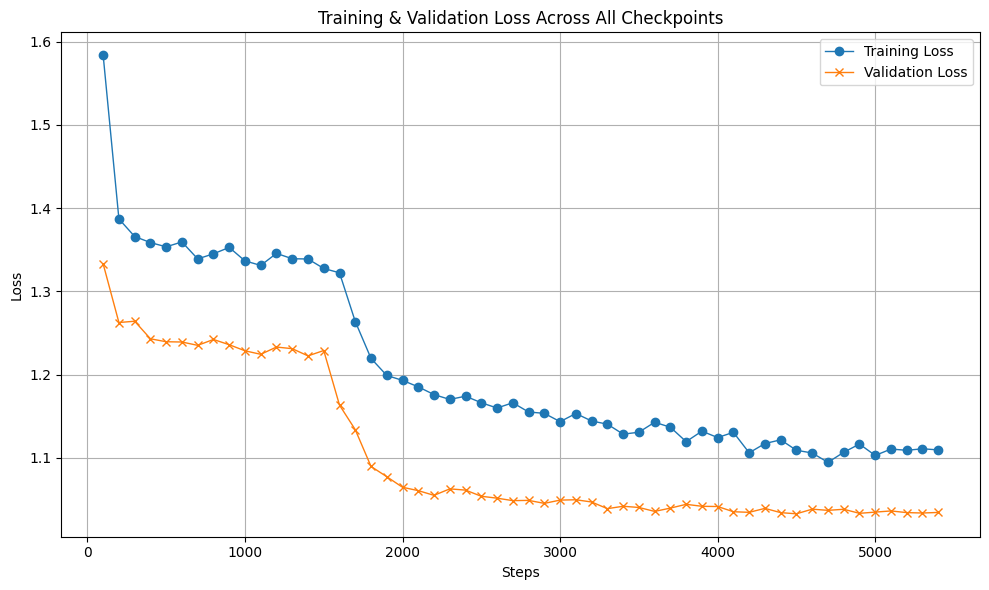

In [ ]:

from datasets import load_dataset
from transformers import AutoFeatureExtractor, AutoTokenizer, VisionEncoderDecoderModel
from PIL import Image
import torch
from tqdm import tqdm

dataset = load_dataset("arampacha/rsicd", split="test")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

predictions = []
references = []

for sample in tqdm(dataset, desc="Generating captions"):
    image = sample['image'].convert("RGB")
    pixel_values = feature_extractor(images=image, return_tensors="pt").pixel_values.to(device)

    output_ids = model.generate(pixel_values, max_length=64)
    caption = tokenizer.decode(output_ids[0], skip_special_tokens=True).strip()

    predictions.append(caption)
    references.append(sample["captions"]) 


In [ ]:


from bert_score import score as bert_score
from rouge_score import rouge_scorer
import sacrebleu

# --- BLEU ---
bleu = sacrebleu.corpus_bleu(predictions, list(zip(*references)))
print(f"\nBLEU score: {bleu.score:.2f}")

# --- ROUGE ---
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
rouge1_f1 = []
rougeL_f1 = []

for pred, ref_list in zip(predictions, references):
    ref = ref_list[0]
    scores = scorer.score(ref, pred)
    rouge1_f1.append(scores['rouge1'].fmeasure)
    rougeL_f1.append(scores['rougeL'].fmeasure)

avg_rouge1 = sum(rouge1_f1) / len(rouge1_f1)
avg_rougeL = sum(rougeL_f1) / len(rougeL_f1)

print(f"ROUGE-1 F1: {avg_rouge1:.4f}")
print(f"ROUGE-L F1: {avg_rougeL:.4f}")

# --- BERTScore ---
flat_refs = [ref[0] for ref in references]
P, R, F1 = bert_score(predictions, flat_refs, lang="en", verbose=True)
print(f"BERTScore F1 (avg): {F1.mean().item():.4f}")


BLEU score: 2.28
ROUGE-1 F1: 0.1586
ROUGE-L F1: 0.1425


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 29/29 [00:05<00:00,  5.16it/s]


computing greedy matching.


100%|██████████| 18/18 [00:00<00:00, 61.23it/s]


done in 5.94 seconds, 184.12 sentences/sec
BERTScore F1 (avg): 86.9
